In [54]:
import numpy as np
import graspy as gp
import matplotlib.pyplot as plt
from graspy.cluster import AutoGMMCluster
from itertools import product
from joblib import Parallel, delayed
import pickle
import seaborn as sns
%matplotlib inline

from sklearn.metrics import adjusted_rand_score

In [31]:
a = 0.01
b = 0.02
c = 0.01
d = 0.002
e = 0.1
f = 0.002
g = 0.015

# a = 0.5
# b = a / 2
# c = a / 20
# d = a 
# e = 1.5 * a
# f = 1.25 * a
# g = a / 2

B = np.array([
    [a, b, c, d],
    [b, e, f, g],
    [c, f, a, b],
    [d, g, b, e]
])

projection1 = np.array([
    [np.mean(B[:2,:2]), np.mean(B[:2,2:])],
    [np.mean(B[:2,2:]), np.mean(B[2:,2:])],
])
print(projection1)

projection2 = np.array([
    [np.mean([a, c, c, a]), np.mean([b, d, f, b])],
    [np.mean([b, d, f, b]), np.mean([e, g, g, e])]
])

print(projection2)

[[0.0375  0.00725]
 [0.00725 0.0375 ]]
[[0.01   0.011 ]
 [0.011  0.0575]]


In [32]:
def experiment(n, rep, B, p=0.25, acorn=None):
    if acorn != None:
        np.random.seed(acorn)
    
    score = np.zeros(4,dtype=float)
    pi = np.array([p, p, p, p])
    A = gp.simulations.sbm((n*pi).astype(int), B)
    
    affinity_labels = np.array(['L'] * (n//2) + ['R'] * (n//2)) #left right
    core_labels = np.tile(["G"] * (n//4) + ["W"] * (n//4), 2) # gray white
    
    lse = gp.embed.LaplacianSpectralEmbed().fit_transform(
    gp.utils.augment_diagonal(A)
    )
    ase = gp.embed.AdjacencySpectralEmbed().fit_transform(A)

    affinity = ['euclidean','manhattan','none']
    lse_gmm = AutoGMMCluster(2, 2, affinity=affinity).fit_predict(lse)
    ase_gmm = AutoGMMCluster(2, 2, affinity=affinity).fit_predict(ase)
    
    score[0] = adjusted_rand_score(lse_gmm, affinity_labels)
    score[1] = adjusted_rand_score(lse_gmm, core_labels)
    score[2] = adjusted_rand_score(ase_gmm, affinity_labels)
    score[3] = adjusted_rand_score(ase_gmm, core_labels)
    
    with open('../../../res/res'+str(n)+'_'+str(rep)+'.pickle','wb') as f:
        pickle.dump(score,f)

In [48]:
nodes = range(1000,11000,1000)
reps = range(1,101,1)
iterable = product(nodes,reps)

#Parallel(n_jobs=-2,verbose=1)(delayed(experiment)(n, rep, B, acorn=n*rep) for n,rep in iterable)
#for n,rep in iterable:
#    print('doing',n,rep)
#    experiment(n, rep, B, acorn=n*rep)

In [49]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [52]:
score = np.zeros((len(nodes),4),dtype=float)

for count,n in enumerate(nodes):
    for rep in reps:
        filename = '../../../res/res'+str(n)+'_'+str(rep)+'.pickle'
        res = unpickle(filename)
        score[count,0] += res[0]
        #print(score[count,0],count)
        score[count,1] += res[1]
        score[count,2] += res[2]
        score[count,3] += res[3]
        
score /= 100
print(score)

[[0.3655463  0.51924701 0.030563   0.87395183]
 [0.87637654 0.10954393 0.08948032 0.75823486]
 [0.26899705 0.72991027 0.15473989 0.57196789]
 [0.1997299  0.79995    0.21233388 0.46120773]
 [0.18982994 0.80996199 0.25987904 0.37951926]
 [0.15985995 0.83997332 0.3249131  0.26485645]
 [0.25989426 0.73996285 0.30992605 0.22991462]
 [0.14989372 0.84998125 0.32993592 0.24992592]
 [0.21991331 0.77997555 0.12490817 0.74497708]
 [0.19991998 0.79998    0.00490086 0.98499887]]


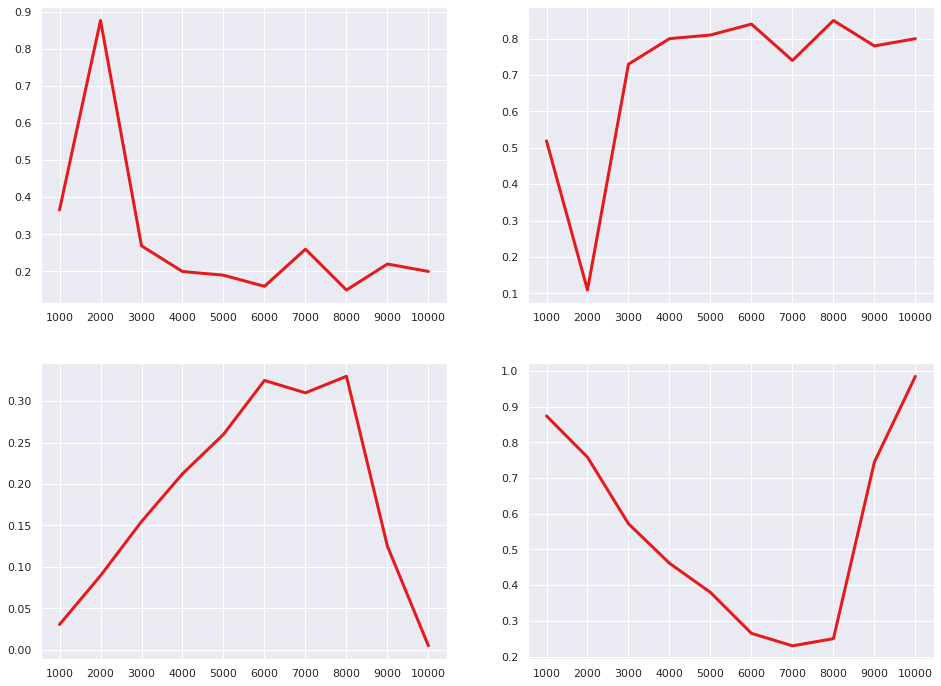

In [61]:
sns.set()
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax[0][0].plot(nodes, score[:,0], linewidth=3, color="#e41a1c")
ax[0][0].set_xticks(nodes)
ax[0][1].plot(nodes, score[:,1], linewidth=3, color="#e41a1c")
ax[0][1].set_xticks(nodes)
ax[1][0].plot(nodes, score[:,2], linewidth=3, color="#e41a1c")
ax[1][0].set_xticks(nodes)
ax[1][1].plot(nodes, score[:,3], linewidth=3, color="#e41a1c")
ax[1][1].set_xticks(nodes)

In [44]:
len(nodes)

10